In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
import torch
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Model input shuld be as same as trained data, so we have to pre-preprocess it 
# and convert it from raw rgb image to normalized tensore
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [5]:
# See if the GPU is available or not
if torch.cuda.is_available():
    use_cuda=True
    device = torch.device("cuda:0")
else:
    use_cuda=False
    device = torch.device("cpu")
    
print(device)

cuda:0


In [6]:
# Load pretrained model
model = resnet18(pretrained=True)
model = model.to(device)

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# We Want to see activation map of last CNN layer
model.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
# Read image, normalize and resize it 
path = "./test_images/cat.png"

rgb_img = cv2.imread(path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])




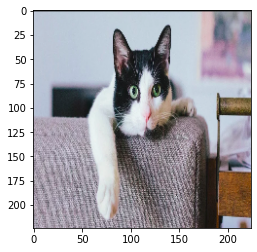

In [10]:
plt.imshow(rgb_img,  cmap="gray")
plt.show()

In [11]:
target_layers = [model.layer4[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

/home/hue/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


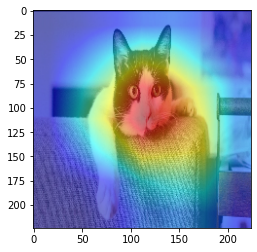

In [12]:
# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization, cmap="gray")
plt.show()